In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def factor(df, window = 96):
    """
    计算极端收益率反转因子(ERR因子)
    步骤:
    1. 计算每根K线的收益率
    2. 按自然日分组，找出每日最极端收益的K线
    3. 计算最极端收益及其前一根K线的收益率
    4. 计算过去20天最极端收益和前一根收益的平均值
    5. 将两个平均值排序后相加得到最终因子值
    """
    # 1. 计算每根K线的收益率
    df = df.copy()
    df['return'] = (df['close'] - df['open']) / df['open']
    
    # 2. 按自然日分组
    df['date'] = df.index.date
    daily_groups = df.groupby('date')
    
    # 存储每日的最极端收益率及其前一根收益率
    extreme_data = []
    
    for date, group in daily_groups:
        if len(group) < 2:  # 至少需要2根K线才能计算前一根
            continue
            
        # 计算每日收益率的中位数
        median_return = group['return'].median()
        
        # 计算每个收益率的偏离度 S = |x - median|
        s_values = (group['return'] - median_return).abs()
        
        # 找到最极端收益的K线(最大S值)
        idx_extreme = s_values.idxmax()
        extreme_row = group.loc[idx_extreme]
        
        # 获取前一根K线的索引
        prev_idx = group.index[group.index.get_loc(idx_extreme) - 1]
        prev_row = df.loc[prev_idx]
        
        # 存储数据
        extreme_data.append({
            'date': date,
            'extreme_return': extreme_row['return'],
            'prev_return': prev_row['return']
        })
    
    # 创建DataFrame
    extreme_df = pd.DataFrame(extreme_data)
    extreme_df['date'] = pd.to_datetime(extreme_df['date'])
    extreme_df.set_index('date', inplace=True)
    
    # 计算过去20天的平均极端收益率和前一根收益率
    extreme_df['mean_extreme'] = extreme_df['extreme_return'].rolling(window).mean()
    extreme_df['mean_prev'] = extreme_df['prev_return'].rolling(window).mean()
    
    # 排序相加(使用排序值代替原始值)
    extreme_df['rank_extreme'] = extreme_df['mean_extreme'].rank(pct=True)
    extreme_df['rank_prev'] = extreme_df['mean_prev'].rank(pct=True)
    extreme_df['err_factor'] = extreme_df['rank_extreme'] + extreme_df['rank_prev']
    
    # 将因子值映射回原始DataFrame
    df = df.reset_index()
    df['date'] = pd.to_datetime(df['open_time'].dt.date)
    df = pd.merge(df, extreme_df[['err_factor']], left_on='date', right_index=True, how='left')
    df.set_index('open_time', inplace=True)
    
    # 向前填充因子值(每月最后一天计算的值用于下个月)
    df['err_factor'] = df['err_factor'].fillna(method='ffill')
    
    return df['err_factor']

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.018550
   Rank_IC (Spearman): 0.011474
📊 信息比率:
   IR: -0.224911
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 121915
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


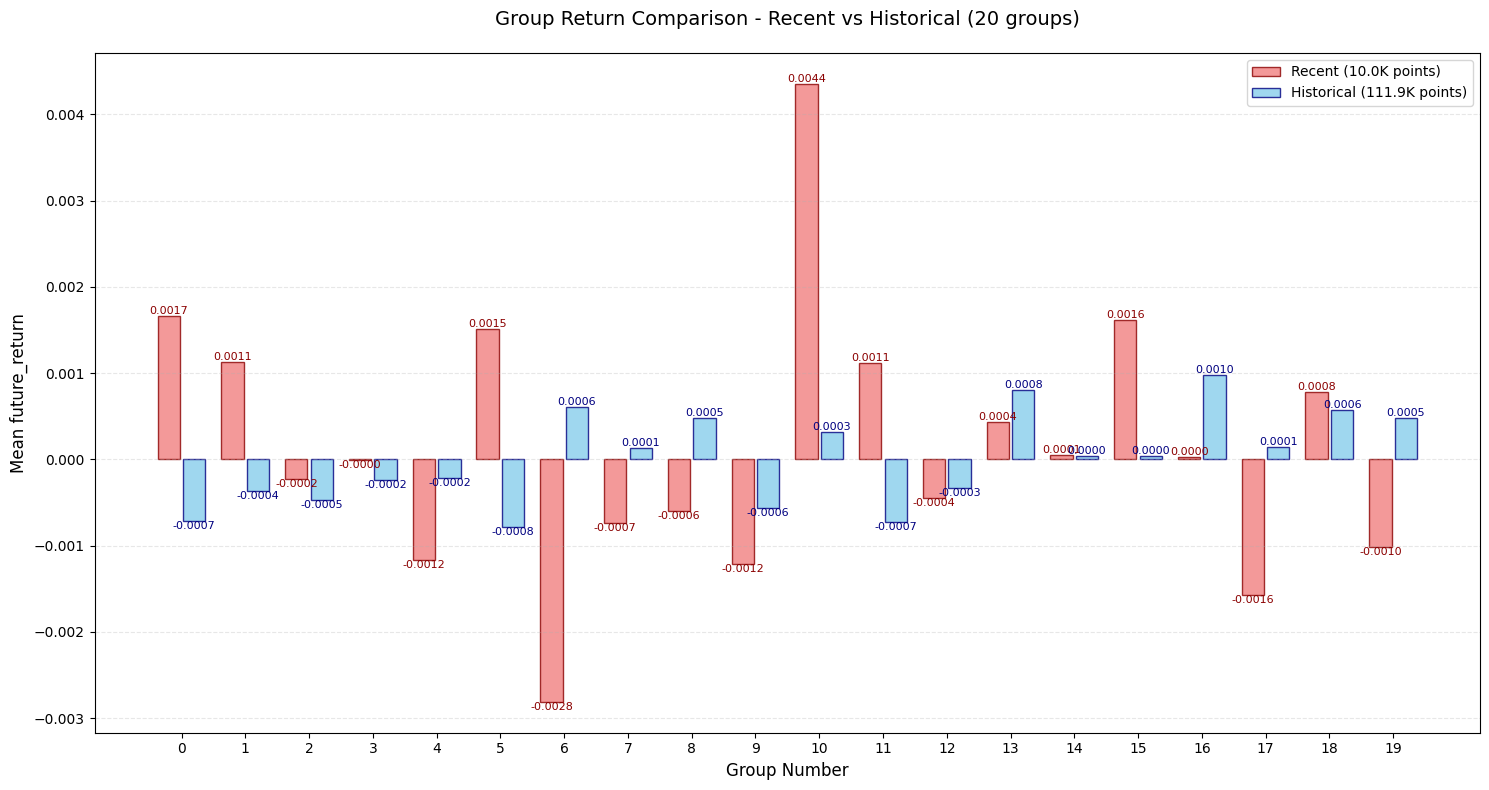

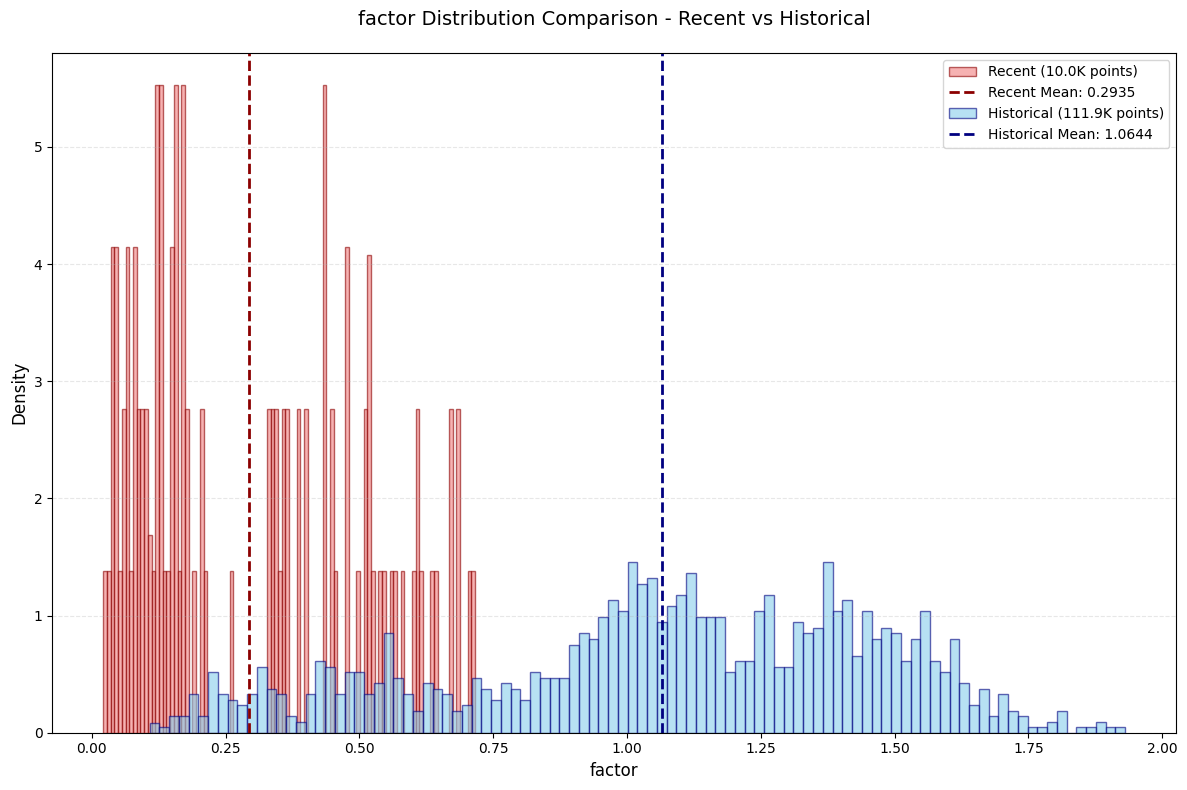

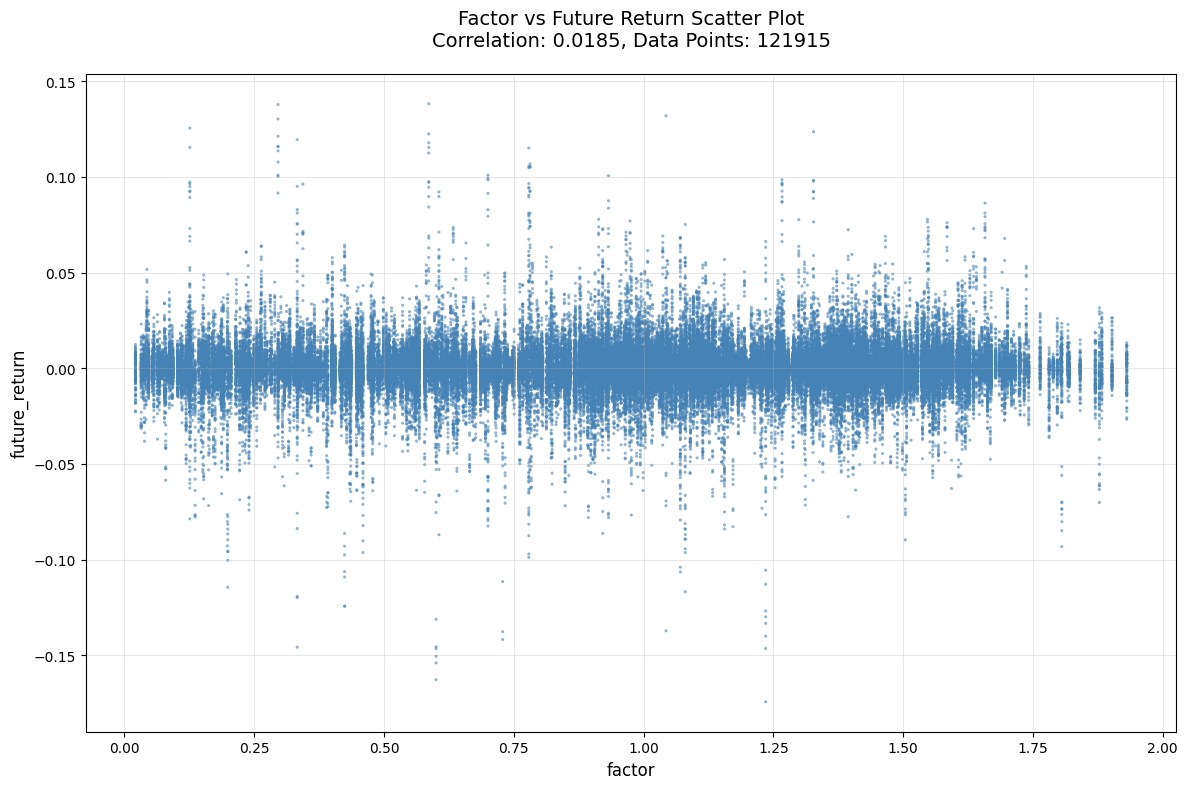

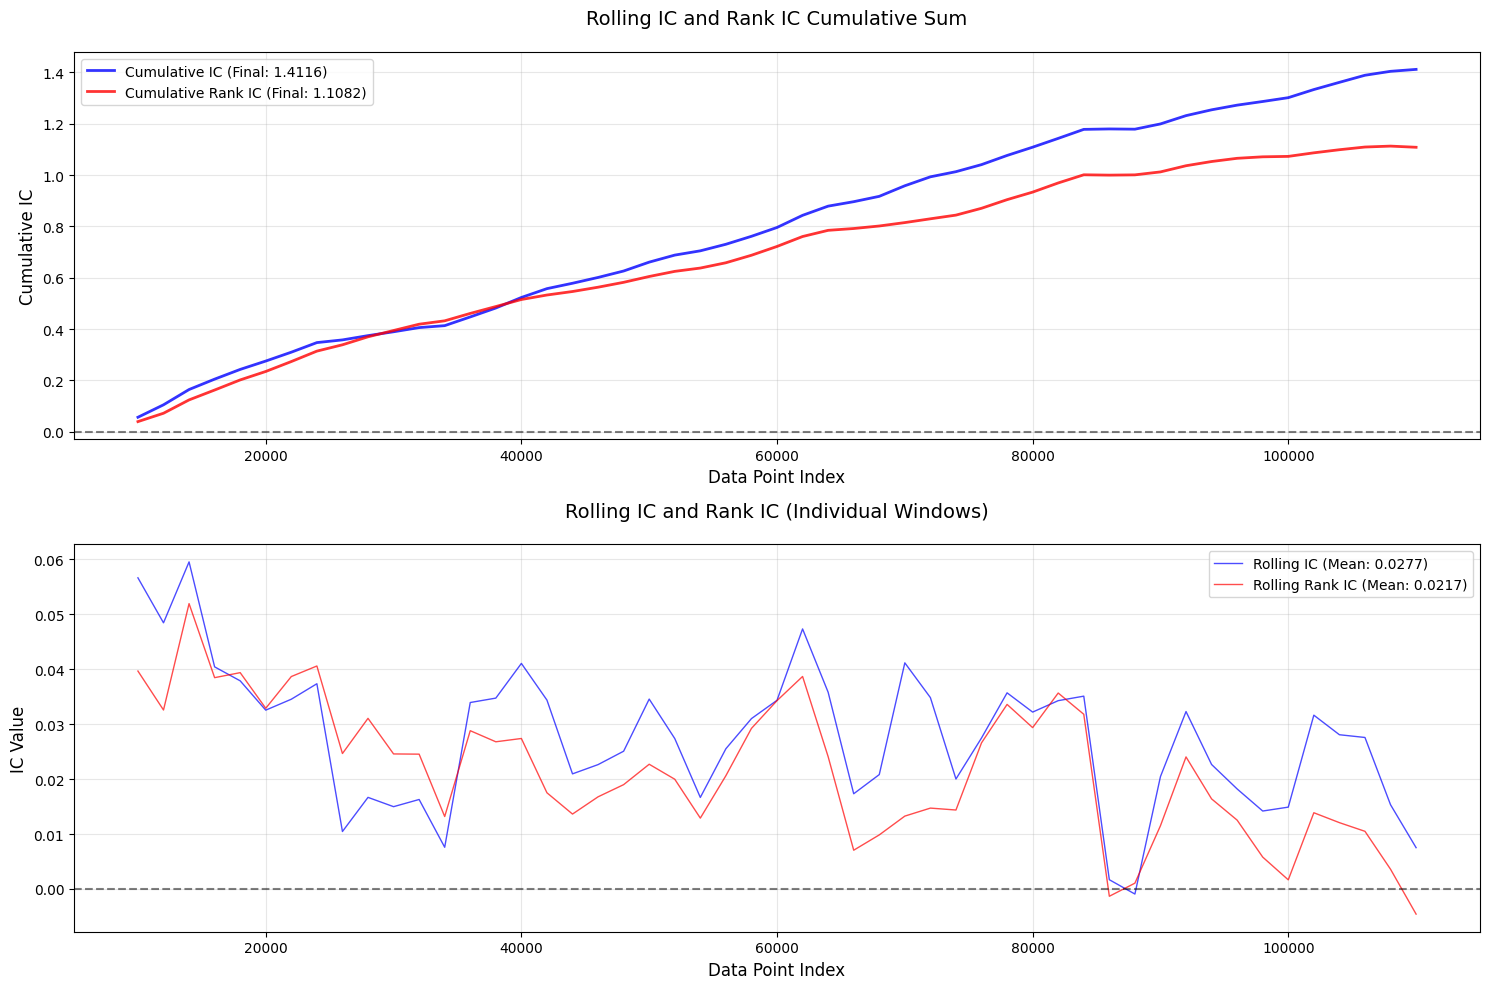

✅ 已显示 4 个图片
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [6]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[0.02538951109625784,
 -0.01597006752932641,
 -0.0192096665800563,
 0.015585759258553905,
 -0.004253697612415529,
 -0.00494894164727868,
 0.029371152625136145,
 -0.025106836844005494,
 -0.007596614505559869,
 -0.04145066487702969]

In [7]:
print(result)

{'correlation_analysis': {'IC': 0.018549965417717133, 'Rank_IC': 0.011473632272693008}, 'information_ratio': {'IR': -0.22491140735781626, 'group_correlations': [0.02538951109625784, -0.01597006752932641, -0.0192096665800563, 0.015585759258553905, -0.004253697612415529, -0.00494894164727868, 0.029371152625136145, -0.025106836844005494, -0.007596614505559869, -0.04145066487702969], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0       0.0212   0.1904    0.1183      -0.0004      0.0126   6144
1       0.1912   0.3336    0.2685       0.0002      0.0142   6144
2       0.3344   0.4516    0.3980      -0.0004      0.0129   6048
3       0.4516   0.5492    0.5002      -0.0003      0.0101   6235
4       0.5492   0.6530    0.5948       0.0002      0.0140   5952
5       0.6554   0.8025    0.7293      -0.0009      0.0150   6144
6       0.8033   0.9111    0.8634     